In [1]:
# Import required modules
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
def create_sequences(X, y, window_size=4):
    X_seq = []
    y_seq = []
    for i in range(window_size, len(X)):
        X_seq.append(X[i - window_size:i])  # collect previous 4 timesteps
        y_seq.append(y[i])                  # target is at current timestep
    return np.array(X_seq), np.array(y_seq)


In [4]:
# Set a random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load the dataset from a CSV file (replace 'your_dataset.csv' with your actual file name)
data = pd.read_csv('TrainingDataStand.csv')

# Separate input features and output feature
X = data.iloc[:, :4].values  
y = data.iloc[:, 4].values

# Create overlapping sequences
X_seq, y_seq = create_sequences(X, y, window_size=4)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [30]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, RNN, GRUCell, Dense, TimeDistributed, GRU

# --- Input: 4 timesteps, 4 features per timestep
inputs = Input(shape=(4, 4), name="sequence_input")

# --- TimeDistributed Dense layer (processes each timestep)
x =  TimeDistributed(Dense(500, activation='relu'))(inputs)

# --- GRU layer with 25 units
# x = GRU(25, activation='relu')(x)
x = GRU(25, activation='relu', return_sequences=False)(x)

# --- Post-GRU Dense layers
x = Dense(500, activation='relu')(x)
x = Dense(500, activation='relu')(x)

# --- Final output (1 for steering, or 3 if you're predicting multiple actions)
output = Dense(1, activation='tanh', name="steering_output")(x)

# --- Compile the model
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='mse')

# --- Print summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 500)         │         2,500 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 25)             │        39,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 500)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ steering_output (Dense)         │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,026 (1.17 MB)

 Trainable params: 306,026 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Specify callback for logging in-epoch loss
from tensorflow.keras.callbacks import Callback
class BatchLossLogger(Callback):
    def on_train_begin(self, logs=None):
        self.batch_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

# Instantiate the callback
batch_loss_logger = BatchLossLogger()

In [31]:
# Start the timer
start_time = time.time()

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(), metrics=['mae'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1,
    batch_size=1024,
    verbose=1,
    callbacks=[batch_loss_logger]
)

# Stop the timer
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Training Time: {elapsed_time:.2f} seconds")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequence_input (InputLayer)     │ (None, 4, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 500)         │         2,500 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 25)             │        39,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 500)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 500)            │       250,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ steering_output (Dense)         │ (None, 1)              │           501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306,026 (1.17 MB)

 Trainable params: 306,026 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

473/473 ━━━━━━━━━━━━━━━━━━━━ 29s 52ms/step - loss: 0.0029 - mae: 0.0302 - val_loss: 0.0013 - val_mae: 0.0232
Training Time: 29.13 seconds


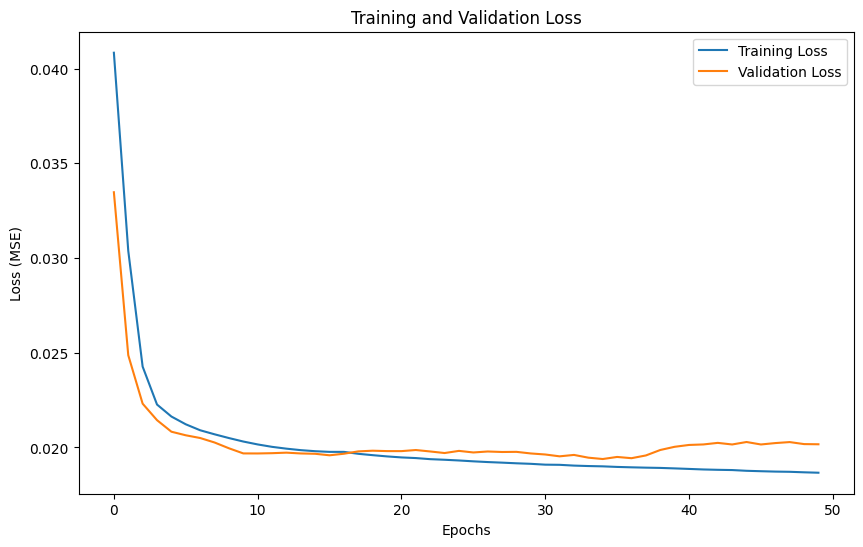

In [7]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(np.sqrt(history.history['loss']), label='Training Loss')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
# plt.ylim([0.001, 0.005])
plt.legend()
plt.show()


3242/3242 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


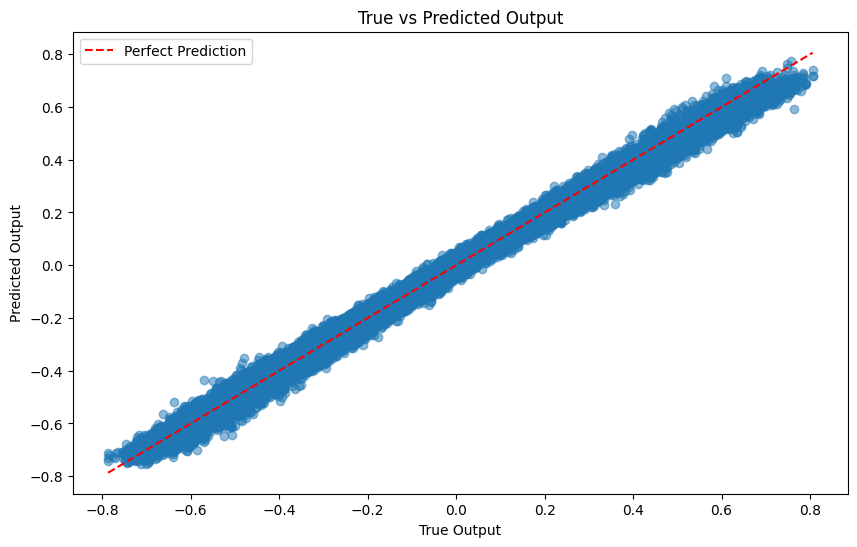

In [8]:
# Predict on test set and visualize results
y_pred = model.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('True vs Predicted Output')
plt.xlabel('True Output')
plt.ylabel('Predicted Output')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.legend()
plt.show()

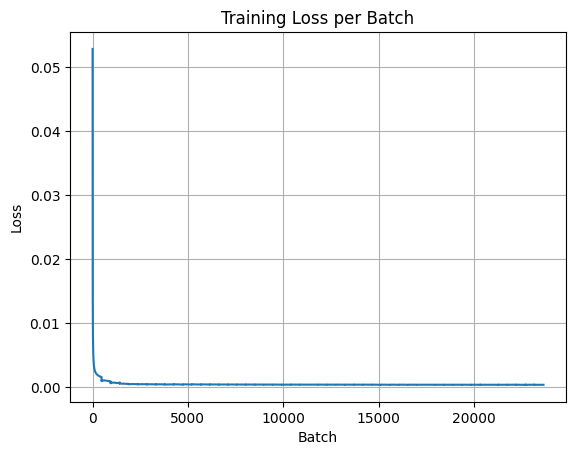

In [14]:
# Plot batch loss
plt.plot(batch_loss_logger.batch_losses)
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss per Batch')
plt.grid(True)
# plt.ylim([0.001, 0.0014])
plt.show()

In [15]:
# Export the model
model.export("SM_ProMoD_1")

INFO:tensorflow:Assets written to: SM_ProMoD_1\assets


INFO:tensorflow:Assets written to: SM_ProMoD_1\assets


Saved artifact at 'SM_ProMoD_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 4), dtype=tf.float32, name='sequence_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1633840919952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006754192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006755344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006753424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006754576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006753616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006756688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006756112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006758224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006757456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1634006759376: TensorSpec(shape=(), dtype=tf

In [9]:
print(X_seq[1])
z = model.predict(np.expand_dims(X_seq[1], axis=0))
print(z)

[[ 0.66344469  0.00952446 -0.40896399  0.00861285]
 [ 0.65010906  0.00951364 -0.48853803  0.00861053]
 [ 0.63413311  0.00951115 -0.40869708  0.00860821]
 [ 0.62080621  0.00951133 -0.40855052  0.00860588]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[-0.01205312]]


In [34]:
CL_sim = np.array([
    [0.340461961342068, 0.00956524669187780, -0.409169800243960, 0.00861633416662310],
          [0.327119947253009, 0.00953440279113678, -0.409032658284689, 0.00861401168130411],
          [0.313782418580409, 0.00951767686925018, -0.408895244084914, 0.00861168919755587],
          [0.300449384359250, 0.00951170338041811, -0.408757557648734, 0.00860936671631734]
          ])

z = model.predict(np.expand_dims((CL_sim), axis=0))
print(z)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
[[-0.00980722]]


In [10]:
import tf2onnx
import onnx

# Convert the model
onnx_model, _ = tf2onnx.convert.from_keras(
    model,
    opset=13,
    input_signature=[tf.TensorSpec([None, 4, 4], tf.float32, name="sequence_input")],
    output_path = "steering_model.onnx"
)



In [35]:
model.export("saved_gru_model_3")

INFO:tensorflow:Assets written to: saved_gru_model_3\assets


INFO:tensorflow:Assets written to: saved_gru_model_3\assets


Saved artifact at 'saved_gru_model_3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4, 4), dtype=tf.float32, name='sequence_input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2189165285584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189165289232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189394795152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189394792848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189394796304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189394793424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189394795920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189406592976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189406593936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189458471248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2189394792080: TensorSpec(shape=(), dt

In [32]:
model.save("saved_gru_model_3.h5")

# Load your model (h5 or keras)
model = tf.keras.models.load_model("saved_gru_model_3.h5")  # or .keras

# Specify input shape explicitly for ONNX
spec = (tf.TensorSpec([None, 4, 4], tf.float32, name="sequence_input"),)

# Export to ONNX
model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=15,
    output_path="steering_model_3.onnx"
)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


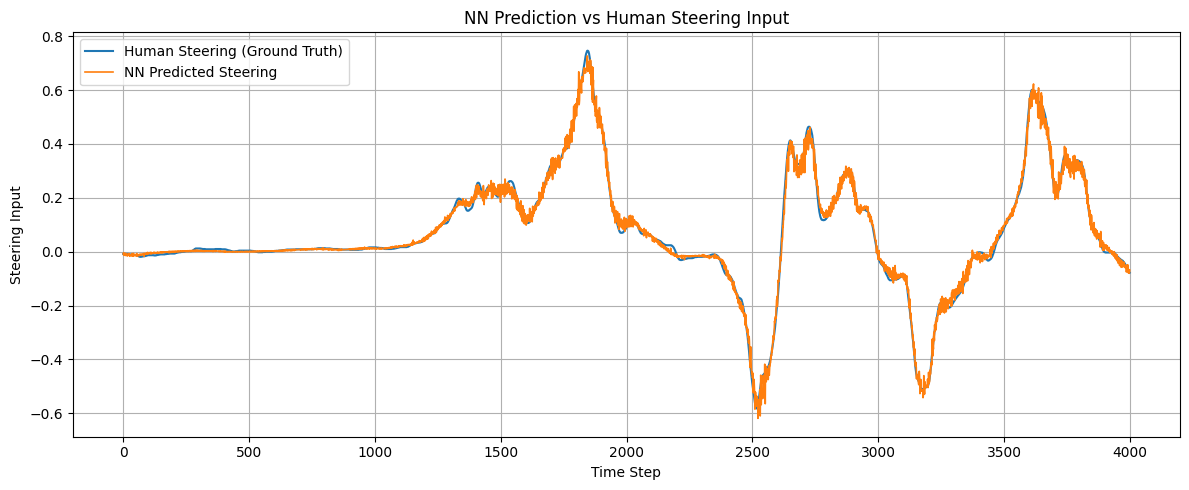

In [ ]:
X_s = X_seq[:6000]
Y_s = y_seq[:6000]

yP = model.predict(X_s)

plt.figure(figsize=(12, 5))
plt.plot(Y_s, label='Human Steering (Ground Truth)', linewidth=1.5)
plt.plot(yP, label='NN Predicted Steering', linewidth=1.2)
plt.xlabel("Time Step")
plt.ylabel("Steering Input")
plt.title("NN Prediction vs Human Steering Input")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
model.save("saved_gru_model_3.keras")  # This creates keras_metadata.pb



In [39]:
import keras
from keras.models import save_model

# Save to TensorFlow SavedModel format (generates keras_metadata.pb!)
save_model(model, "saved_gru_model_tf")  # no extension, no save_format arg


ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=saved_gru_model_tf.